# Estimating future heat stress using wet-bulb temperature

We know that temperatures are rising and that climate extremes can have potentially disastrous consequences for many people. 

One concern is heat stress, worsened by high humidity. As humididty increases, our bodys' are less able to remove heat due to evaporative cooling. This is why _dry_ heat feels more bearable than _humid_ heat.

One way to quantify the combined effect of heat and humidity on humans is **wet bulb temperature**.

[“The wet-bulb temperature is the lowest temperature that can be reached under current ambient conditions by the evaporation of water only”](https://en.wikipedia.org/wiki/Wet-bulb_temperature#:~:text=Wet%2Dbulb%20temperature%20and%20health,-See%20also%3A%20Effects&text=A%20sustained%20wet%2Dbulb%20temperature,to%20gaining%20heat%20from%20it.). 

Sustained wet bulb temperatures of above 35$^\circ$C will result in hypthermia and eventually death even in well-trained and healthy humans ([Sherwood and Huber 2010](https://www.pnas.org/doi/10.1073/pnas.0913352107)).  

Wet bulb temperature can be approximated as: 

![](https://journals.ametsoc.org/view/journals/apme/50/11/jamc-d-11-0143.1-e1.gif)

*Source: Stull, [
Wet-Bulb Temperature from Relative Humidity and Air Temperatur](https://journals.ametsoc.org/view/journals/apme/50/11/jamc-d-11-0143.1.xml), Journal of Applied Climatology and Meteorology, 2267-2269, 2011*

## Purpose

In this demonstration, we will look at wet bulb temperature trends and climate projections of wet bulb temperature. e
This demo continues the previous CMIP demo and uses many of the same steps. 


In [1]:
from xmip.preprocessing import combined_preprocessing
from xmip.utils import google_cmip_col
from xmip.postprocessing import match_metrics
import matplotlib.pyplot as plt

We again create a collection of all available CMIP data to browse 

In [2]:
col = google_cmip_col()
col

,unique
activity_id,18
institution_id,36
source_id,88
experiment_id,170
member_id,657
table_id,37
variable_id,700
grid_label,10
zstore,514818
dcpp_init_year,60


Next we select air temperature and relative humidity data from historical climate simulations. 

The variable names and the table where they can be found is in this [spreadsheet](https://docs.google.com/spreadsheets/d/1UUtoz6Ofyjlpx5LdqhKcwHFz2SGoTQV2_yekHyMfL9Y/edit#gid=1221485271)


In [3]:

# create a smaller catalog from the full collection using faceted search
cat = col.search(
    variable_id=['tas', 'hurs'], # atmospheric surface temperature & relative humidity 
    experiment_id='historical', # only runs for the historical forcing period
    table_id='Amon', # monthly atmospheric data
    grid_label='gn', #native model grid only
    source_id=['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1'], #lets restrict us here to only a single member
)

# read all datasets into a dictionary but apply the xmip preprocessing before
ddict_historical = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


We repeat the same thing for `ssp585` and `ssp245` projections, whicha are the *worst-case* and *middle-of-the-road* scenarios

In [4]:
# create a smaller catalog from the full collection using faceted search
cat = col.search(
    variable_id=['tas', 'hurs'], # atmospheric surface temperature & relative humidity 
    experiment_id='ssp585', # only runs for the ssp585 scenario
    table_id='Amon', # monthly atmospheric data
    grid_label='gn', #native model grid only
    source_id=['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1'], #lets restrict us here to only a single member
)

# read all datasets into a dictionary but apply the xmip preprocessing before
ddict_ssp585 = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [5]:
# create a smaller catalog from the full collection using faceted search
cat = col.search(
    variable_id=['tas', 'hurs'], # atmospheric surface temperature & relative humidity 
    experiment_id='ssp245', # only runs for the ssp245 scenario
    table_id='Amon', # monthly atmospheric data
    grid_label='gn', #native model grid only
    source_id=['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1'], #lets restrict us here to only a single member
)

# read all datasets into a dictionary but apply the xmip preprocessing before
ddict_ssp245 = cat.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True},
)


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


Like last time, we also need the grid cell area average, to be able to calculate global means

In [6]:
# Repeat the above steps to get the cell area matching the temperature we loaded earlier
cat_area = col.search(
    variable_id='areacella', # the cell area is a different variable in the collection
    table_id='fx', # since area is not varying in time we need to specify a different table_id
    experiment_id='historical', # Same as before
    grid_label='gn', # Same as before
    source_id=['NorESM2-MM', 'MPI-ESM1-2-LR', 'CanESM5'], # only choosing a few models here, there are many more!
    member_id=['r1i1p1f1'], #lets restrict us here to only a few members, you can modify this later to experiment.
)
# read all datasets into a dictionary (make sure to apply the same preprocessing as before!)
ddict_area = cat_area.to_dataset_dict(
    preprocess=combined_preprocessing,
    xarray_open_kwargs={'use_cftime':True}
) 


--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


We can add the area to our data

In [7]:
ddict_historical_w_area = match_metrics(ddict_historical, ddict_area, 'areacella', dim_length_conflict='align')
ddict_ssp245_w_area = match_metrics(ddict_ssp245, ddict_area, 'areacella', dim_length_conflict='align')
ddict_ssp585_w_area = match_metrics(ddict_ssp585, ddict_area, 'areacella', dim_length_conflict='align')

You can see that we have three different models. Lets look at them in a bit more detail to understand the layout:

In [8]:
ddict_historical_w_area['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn']

<xarray.Dataset> Size: 294MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, y: 96,
                     x: 192, bnds: 2, vertex: 4)
Coordinates: (12/14)
    height          float64 8B 2.0
  * y               (y) float64 768B -88.57 -86.72 -84.86 ... 84.86 86.72 88.57
  * x               (x) float64 2kB 0.0 1.875 3.75 5.625 ... 354.4 356.2 358.1
  * time            (time) object 16kB 1850-01-16 12:00:00 ... 2014-12-16 12:...
    lat_bounds      (y, bnds, x) float64 295kB dask.array<chunksize=(96, 2, 192), meta=np.ndarray>
    time_bounds     (time, bnds) object 32kB dask.array<chunksize=(1980, 2), meta=np.ndarray>
    ...              ...
    lat             (x, y) float64 147kB -88.57 -86.72 -84.86 ... 86.72 88.57
    lon_verticies   (vertex, x, y) float64 590kB dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
    lat_verticies   (vertex, x, y) float64 590kB dask.array<chunksize=(1, 192, 96), meta=np.ndarray>
  * member_id       (member_id) object 8B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
    areacella       (member_id, dcpp_init_year, y, x) float32 74kB dask.array<chunksize=(1, 1, 96, 192), meta=np.ndarray>
Dimensions without coordinates: bnds, vertex
Data variables:
    hurs            (member_id, dcpp_init_year, time, y, x) float32 146MB dask.array<chunksize=(1, 1, 990, 96, 192), meta=np.ndarray>
    tas             (member_id, dcpp_init_year, time, y, x) float32 146MB dask.array<chunksize=(1, 1, 990, 96, 192), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                      CF-1.7 CMIP-6.2
    activity_id:                      CMIP
    branch_method:                    standard
    branch_time_in_child:             0.0
    branch_time_in_parent:            0.0
    cmor_version:                     3.5.0
    ...                               ...
    intake_esm_attrs:member_id:       r1i1p1f1
    intake_esm_attrs:table_id:        Amon
    intake_esm_attrs:grid_label:      gn
    intake_esm_attrs:_data_format_:   zarr
    DODS_EXTRA.Unlimited_Dimension:   time
    intake_esm_dataset_key:           CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amo...

You can see that both datasets have the same names for many of the coordinates (e.g. 'x' and 'y' for the logical indices in zonal and meridional direction). This is actually not always the case for the raw CMIP6 data, which is why [xMIP](https://github.com/jbusecke/xMIP) was developed in an effort to crowdsource these common data-cleaning tasks. For this example we only use the `combined_preprocessing` function which fixes some of the naming, but check out the [docs](https://cmip6-preprocessing.readthedocs.io/en/latest/?badge=latest) to see more helpful code for CMIP analysis.

Ok but now lets analyze the data! 

We can create a simple plot, right from data in the cloud!

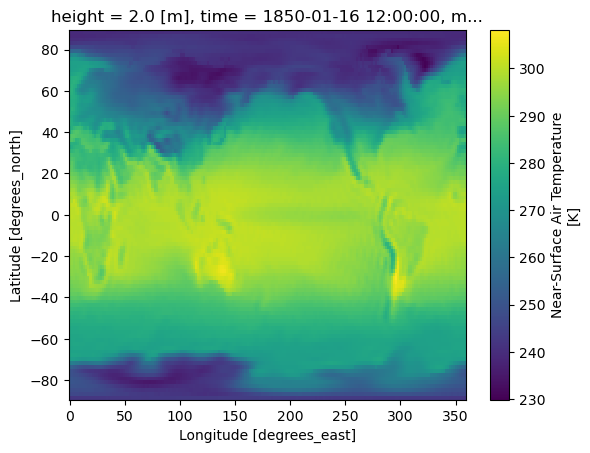

In [9]:
ddict_historical_w_area['CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn'].isel(time=0).sel(member_id = 'r1i1p1f1').tas.plot()

As a next step, we define a function that will calculate wet bulb temperature. This is simply putting the above euqation into Python lingo

In [10]:
import numpy as np
def wetbulb(T,rh):
    T = T-273.15 # the models give T in Kelvin not C
    return T * np.arctan(0.151977*(rh+8.313659)**0.5) + np.arctan(T + rh) - np.arctan(rh-1.676311) + 0.00391838*rh**(3/2)*np.arctan(0.023101*rh)-4.686

Next, we create time series plots. Rather than plotting the average of wetbulb temperature, we look at the 90th percentile (i.e. extreme values)

CMIP.MPI-M.MPI-ESM1-2-LR.historical.Amon.gn
CMIP.NCC.NorESM2-MM.historical.Amon.gn
CMIP.CCCma.CanESM5.historical.Amon.gn


Text(0.5, 1.0, 'Historical')

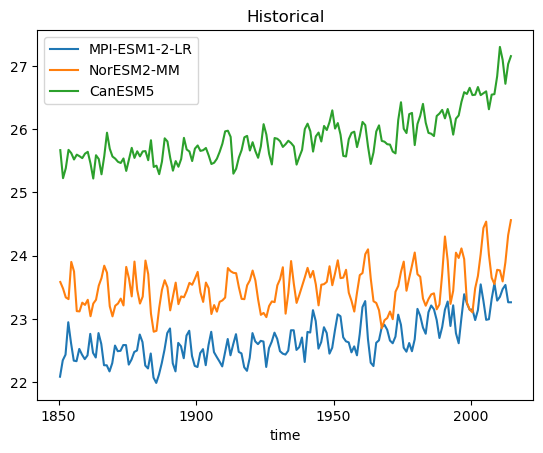

In [11]:
plt.figure()
for name, ds in ddict_historical_w_area.items():
    print(name)

    weights = ds.areacella.fillna(0)
    wb_temp_90_weighted =  wetbulb(ds.tas, ds.hurs).quantile(.9,['x','y']).weighted(weights).mean(['x', 'y']).coarsen(time=12).mean()

    wb_temp_90_weighted.plot(label = ds.attrs['source_id'])
    # lets also plot the average over all members
    #mean_temp.mean('member_id').plot(color='k', linewidth=2)
    #plt.title(ds.attrs['source_id']) #Extract the model name right from the dataset metadata

plt.legend()
plt.title('Historical')

ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn
ScenarioMIP.NCC.NorESM2-MM.ssp245.Amon.gn


Text(0.5, 1.0, 'ssp245')

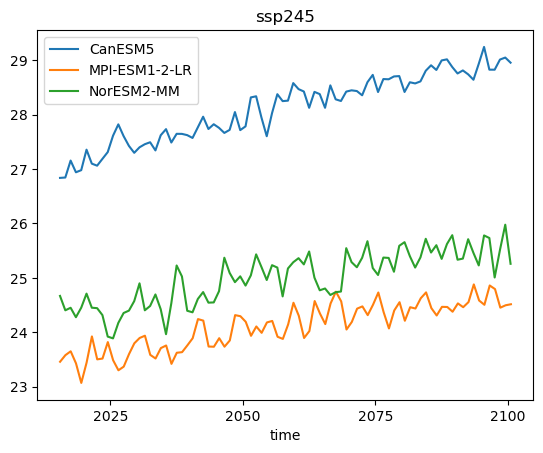

In [12]:
plt.figure()
for name, ds in ddict_ssp245_w_area.items():
    print(name)

    weights = ds.areacella.fillna(0)
    wb_temp_90_weighted =  wetbulb(ds.tas, ds.hurs).quantile(.9,['x','y']).weighted(weights).mean(['x', 'y']).coarsen(time=12).mean()

    wb_temp_90_weighted.plot(label = ds.attrs['source_id'])
    # lets also plot the average over all members
    #mean_temp.mean('member_id').plot(color='k', linewidth=2)
    #plt.title(ds.attrs['source_id']) #Extract the model name right from the dataset metadata

plt.legend()
plt.title('ssp245')

ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn
ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn
ScenarioMIP.NCC.NorESM2-MM.ssp585.Amon.gn


Text(0.5, 1.0, 'ssp585')

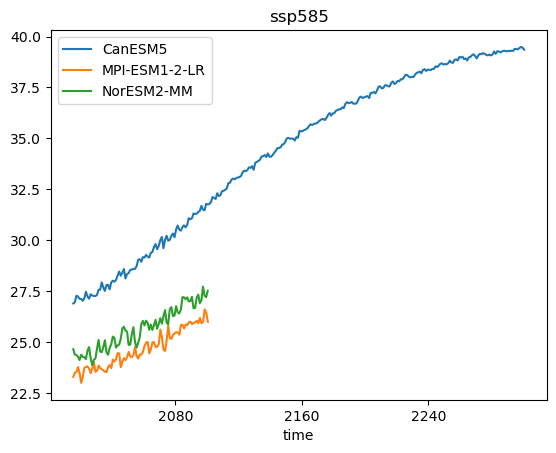

In [13]:
import pandas as pd
plt.figure()
for name, ds in ddict_ssp585_w_area.items():
    print(name)

    weights = ds.areacella.fillna(0)
    wb_temp_90_weighted =  wetbulb(ds.tas, ds.hurs).quantile(.9,['x','y']).weighted(weights).mean(['x', 'y']).coarsen(time=12).mean()

    wb_temp_90_weighted.plot(label = ds.attrs['source_id'])
    # lets also plot the average over all members
    #mean_temp.mean('member_id').plot(color='k', linewidth=2)
    #plt.title(ds.attrs['source_id']) #Extract the model name right from the dataset metadata

plt.legend()
plt.title('ssp585')

Let's see how things are looking at the end of the century. 

We can see, which areas are worst off and what are the extremes that we find. To do so, we plot the 90th percentile of wet bulb temperatures on a map and constrain the colormap to values between 20 and 30 C. 

Text(0.5, 1.0, 'CanESM5 ssp245')

c:\Users\jessr\anaconda3\envs\cmip\Lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


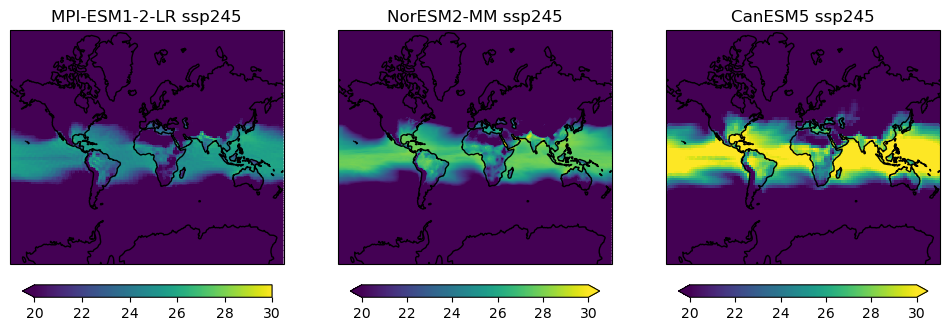

In [14]:
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

fig, ax = plt.subplots(ncols=3, figsize=(12,6), subplot_kw=dict(projection=ccrs.Mercator()))

# ax refers to the subplot object and goes from 0 to 2. 
# Here i am looping over all subplots to add the statelines and to set the boundary of the plotted map.
for i in range(3):
    ax[i].coastlines(linewidth=1)


ds=ddict_ssp245_w_area['ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp245.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[0],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[0].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])

ds=ddict_ssp245_w_area['ScenarioMIP.NCC.NorESM2-MM.ssp245.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[1],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[1].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])

ds=ddict_ssp245_w_area['ScenarioMIP.CCCma.CanESM5.ssp245.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[2],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[2].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])

Text(0.5, 1.0, 'CanESM5 ssp585')

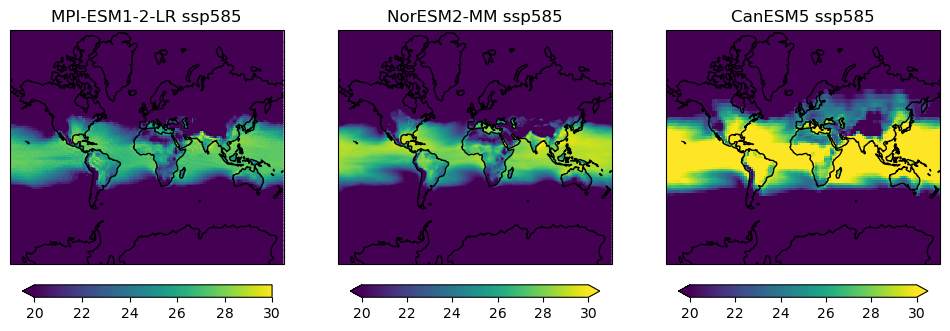

In [15]:
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list

fig, ax = plt.subplots(ncols=3, figsize=(12,6), subplot_kw=dict(projection=ccrs.Mercator()))

# ax refers to the subplot object and goes from 0 to 2. 
# Here i am looping over all subplots to add the statelines and to set the boundary of the plotted map.
for i in range(3):
    ax[i].coastlines(linewidth=1)


ds=ddict_ssp585_w_area['ScenarioMIP.MPI-M.MPI-ESM1-2-LR.ssp585.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[0],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[0].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])

ds=ddict_ssp585_w_area['ScenarioMIP.NCC.NorESM2-MM.ssp585.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[1],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[1].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])

ds=ddict_ssp585_w_area['ScenarioMIP.CCCma.CanESM5.ssp585.Amon.gn']
wetbulb(ds.tas, ds.hurs).sel(time=slice('2099-01-01','2100-01-01')).quantile(.9,['time']).plot(ax=ax[2],
                                                                                      transform=ccrs.PlateCarree(), vmin = 20, vmax = 30,
                                                                                     cbar_kwargs={"orientation": "horizontal", "fraction": 0.027, "pad": 0.045})
ax[2].set_title(ds.attrs['source_id'] + ' ' + ds.attrs['experiment_id'])